In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import vapeplot 
from scipy import interp
import scipy.stats
%matplotlib inline

#### Goal
--------------------

The goal of this project is to make a classifier that predicts the final rankings for bakers.
The idea is to make a model for each episode and to use data from previous episodes in the model.
Therefore, a classifier for episode 1 will likely be bad at predicting the final outcome, but a classifier for episode 5 might accurately predict who will be in the top 3 and who might be eliminated in the next episode



#### Technical Challenge Rankings
--------------------------
* tech_med : median technical challenge ranking over each episode
* tech_mean : same as `tech_med` but the mean
* tech : technical challenge ranking for that episode

In [2]:
tech = pd.read_csv("../RESULTS/gbbo.techinical.data.20190907.tsv",sep='\t')
feats = ['tech_mean','tech_med','tech']

# tier the classes. 
# 0 = Winner
# 1 = Semi-finalist
# 2 = 3-4 place
# 3 = 5-7 place
# 4 = 8- place

classes = np.array(tech['place'])
trans = []
for x in classes:
    if x==1: c=0
    if x==2: c=1
    if x>=3 and x<=4: c=2
    if x>=5 and x<=7: c=3
    if x>=8: c=4
    trans.append(c)

tech['place']=trans

tech.head()

,season,baker,index,episode,tech_mean,tech_med,tech,place
0,1,Annetha,6,1,2.00,2.0,2,3
1,1,Annetha,6,2,4.50,4.5,7,3
2,1,Annetha,6,3,3.00,2.0,0,3
3,1,Annetha,6,4,2.25,1.0,0,3
4,1,Annetha,6,5,1.80,0.0,0,3


In [3]:
from sklearn.preprocessing import QuantileTransformer
def quantile_scale(df,feats):
    qua = df
    scaler = QuantileTransformer(
        n_quantiles=10,
        random_state=42,
        ignore_implicit_zeros=True, #sparse matrix
    )
    # fit the scaler
    scaler.fit(qua[feats])
    # transform values
    qua[feats] = scaler.transform(qua[feats])
    return qua

In [4]:
epi=sorted(list(set(tech['episode'])))
for x in epi:
    print('EPISODE:',x,
          '  Training Set Length: ',
          len(tech.loc[tech['episode']==x]))

EPISODE: 1   Training Set Length:  103
EPISODE: 2   Training Set Length:  103
EPISODE: 3   Training Set Length:  103
EPISODE: 4   Training Set Length:  103
EPISODE: 5   Training Set Length:  103
EPISODE: 6   Training Set Length:  103
EPISODE: 7   Training Set Length:  93
EPISODE: 8   Training Set Length:  93
EPISODE: 9   Training Set Length:  81
EPISODE: 10   Training Set Length:  81


#### Training Strategy
---------------------
For each episode, we evaluate the performance of classifier using two different methods.

* Leave-One-Out (`loo`) 

* Stratified Cross Validation (`scv`)

For `loo` we set aside 1 season as the test set, and train on the remaining seasons. We do this iteratively untill all seasons are evaluated. 

For `scv` we randomly subsample 1/5th of the dataset for testing and train on the remaining 4/5ths. Stratified means that random subsampling will keep the same proportion of class labels (here final rankings). Keeping the same proportion of class labels ensures that label is represented in the test and training sets. Like `loo`, this process is done iteratively so that each fold is evaluated. 

----------------

#### Classifiers 
----------------

We want to test the performance of different classifiers on our data. Different methods work better for different distributions of data (linear vs. non-linear). 

* Linear Support Vector Machine (SVM) 
* RBF SVM 
* Stochastic Gradient Descent (SGD)
* K Nearest Neighbors
* Gaussian Naive Bayes
* Decision Trees
* Random Forest
* Neural Network


In [5]:
# classifiers
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings("ignore")
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from collections import OrderedDict
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.activations import relu

reg = keras.regularizers.l1_l2(l1=0.0001, l2=0.0001)
opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999,  decay=1e-09)
nn = Sequential([
    Dense(800, input_shape=(2, ), activation='relu',kernel_regularizer=reg),
    Dropout(0.1),
    Dense(800, activation='relu',kernel_regularizer=reg),
    Dropout(0.1),
    Dense(300, activation='relu',kernel_regularizer=reg),
    Dropout(0.1),
    Dense(5, activation='softmax')
])
nn.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


clfs = OrderedDict({
    'Linear SVM' : SVC(kernel='linear',probability=True),
    'RBF SVM' : SVC(kernel='rbf',probability=True),
    'SGD' : SGDClassifier(loss='log'),
    'KNN' : KNeighborsClassifier(),
    'Gaussian NB' : GaussianNB(),
    'Descision Trees' : DecisionTreeClassifier(),
    'Random Forest' : RandomForestClassifier(n_estimators=100),
    'MLP' : MLPClassifier(hidden_layer_sizes=(100),max_iter=1000), #0.001
    'Neural Network' : nn
})

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




#### Performance Evaluation 
--------------------------

Record the receiver operating characteristic (ROC) curve. The area under the curve (AUC) is indicative of the performance, an AUC of 1 means the classifier makes perfect predictions. An AUC below 0.5 suggests the classifier is worse than selecting labels at random. 

ROC curves are useful when classes are balanced. In this case, the class labels are balanced for each episode. For datasets with strong class imbalances, the precision-recall curve is a better indicator of performance.

We will record the average ROC and the 95% Confidence Intervals for each episode and classifier 

In [6]:
def calc_95ci(a,confidence=0.95):
    a = 1.0 * np.array(a)
    n = len(a)
    m, se = np.nanmean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h

def return_training_test_sets(df,feats,season):
    test = df.loc[df['season']==season].sample(frac=1.) # shuffles the data
    train= df.loc[df['season']!=season].sample(frac=1.)
    X_test, y_test = [],[]
    X_train, y_train = [],[]
    if len(test)>0:
        test = quantile_scale(test,feats)
        train = quantile_scale(train,feats)
        X_test, y_test = test[feats], test['place']
        X_train, y_train = train[feats], train['place']
    return X_train,y_train, X_test,y_test
# LOO 
def gbbo_loo(df,clfs,feats):
    results={} #(episodes,classifiers) = [ ]
    # then once the results are evaluated, take the mean and 95% 
    seasons = sorted(list(set(df['season'])))
    episodes= sorted(list(set(df['episode'])))
    
    for e in episodes:
        # split test and training set
        tmp = df.loc[df['episode']==e]
        print('EPISODE:',e)
        for clf_name in clfs:
            clf = clfs[clf_name]
            tprs, aucs, mean_fpr= [], [], np.linspace(0, 1, 100)

            for s in seasons:
                X_train, y_train, X_test, y_test = return_training_test_sets(tmp,feats,s)
                
                # skip if there are no episode data for the test season
                if len(X_test)==0: continue
                classes = sorted(list(set(y_train)))
                if clf_name=='Neural Network':
                    clf.fit(X_train,y_train,validation_split=0., batch_size=30, epochs=10,verbose=0)
                else: clf.fit(X_train,y_train)
                # calculate the probability for each class
                probs = clf.predict_proba(X_test)
                # binarize labels
                tests = label_binarize(y_test,classes)
                # reformat data in a dumb way
                t, p = [],[]
                for i,c in enumerate(classes):
                    for x in tests[:,i]: t.append(x)
                    for x in probs[:,i]: p.append(x)
                # calculate ROC curve
                fpr, tpr, thresholds = roc_curve(t,p)
                # append to lists
                tprs.append(interp(mean_fpr, fpr, tpr))
                tprs[-1][0] = 0.0
                roc_auc = auc(fpr, tpr)
                aucs.append(roc_auc)
            # calculate mean and 95% confidence intervals
            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = auc(mean_fpr, mean_tpr)
            ci_auc = calc_95ci(aucs)
            ci_tpr = calc_95ci(tprs)
            tprs_upper = np.minimum(mean_tpr + ci_tpr, 1)
            tprs_lower = np.maximum(mean_tpr - ci_tpr, 0)
            # save results for later plotting
            results[(e,clf_name)]=(mean_fpr, mean_tpr,mean_auc,ci_auc,tprs_upper,tprs_lower)
    
    return results          

In [7]:
# since tech_mean and tech_med are highly correlated, we will only train
# on tech_mean since the data is normally distributed

feats = ['tech_mean','tech']
results = gbbo_loo(tech,clfs,feats)

EPISODE: 1
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
EPISODE: 2
EPISODE: 3
EPISODE: 4
EPISODE: 5
EPISODE: 6
EPISODE: 7
EPISODE: 8
EPISODE: 9
EPISODE: 10


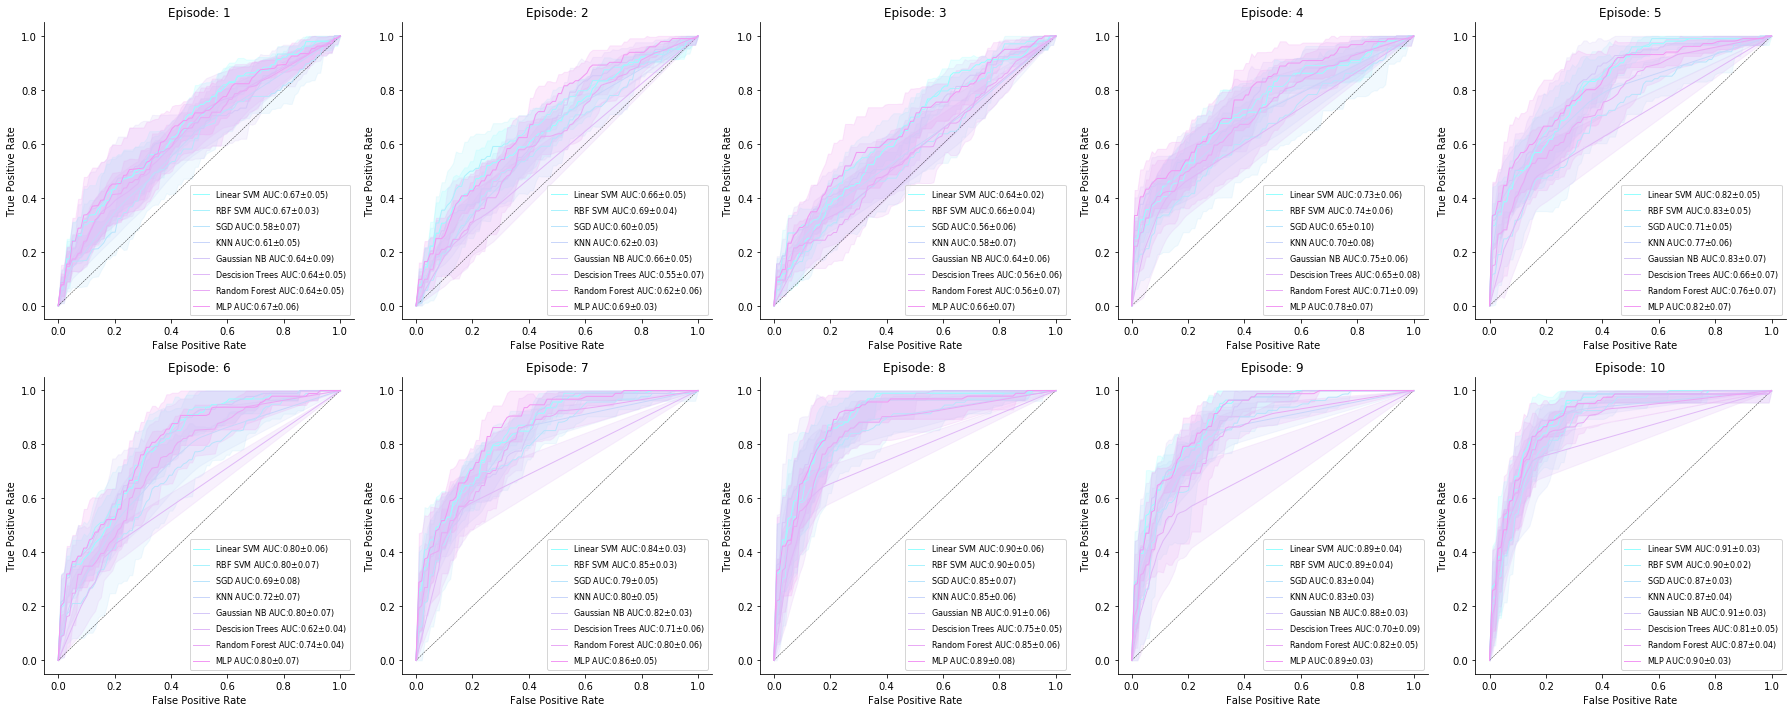

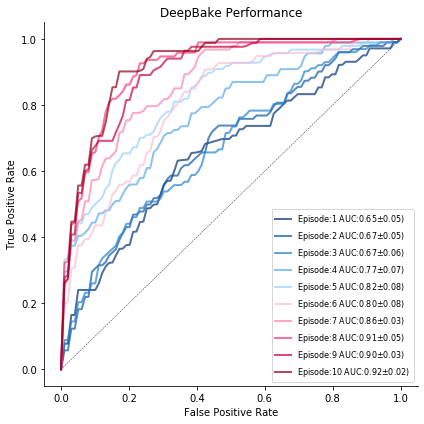

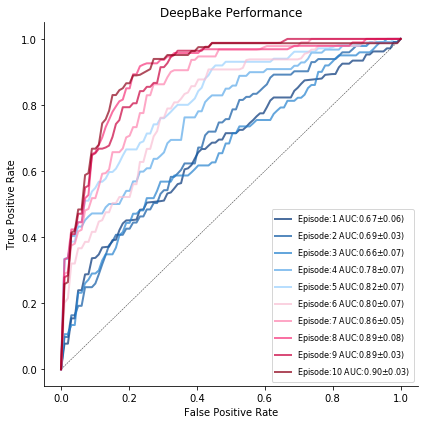

In [10]:
# plot results
from datetime import datetime
def timestamp(): return datetime.today().strftime('%Y%m%d')
def format_roc_plot(ax):
    vapeplot.despine(ax)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right",fontsize=8) 
    
def plot_results(results,episodes,axes):
    colr = ['#96ffff', '#aaf2fd', '#bae4fc', '#c9d6fa', '#d5c8f8', '#e0b9f7', '#e9aaf5', '#f299f3']
    for e,ax in zip(episodes,axes.flatten()):
        # plot the chance line
        ax.plot([0, 1], [0, 1], linestyle='--', lw=0.5, color='k',alpha=.8)    

        for c,clf_name in zip(colr,list(clfs.keys())):
            mean_fpr, mean_tpr,mean_auc,ci_auc,tprs_upper,tprs_lower = results[(e,clf_name)]
            ax.plot(mean_fpr, mean_tpr, color=c,label=r'%s AUC:%0.2f$\pm$%0.2f)' % (clf_name,mean_auc, ci_auc),lw=1)
            ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=c, alpha=.2)
        format_roc_plot(ax)
        ax.set_title('Episode: {}'.format(e))
# plot only the Neual Network
def plot_nn_results(results,episodes,ax,clf_name='Neural Network'):
    colr = ['#003277', '#0e58a3', '#2380ce', '#5ba9e9', '#9ad1fe', '#f9bfd4', '#fe82ae', '#f7357c', '#c9003f', '#8e0018']
    # plot the chance line
    ax.plot([0, 1], [0, 1], linestyle='--', lw=0.5, color='k',alpha=.8)    
    for c,e in zip(colr,episodes): 
        mean_fpr, mean_tpr,mean_auc,ci_auc,tprs_upper,tprs_lower = results[(e,clf_name)]
        ax.plot(mean_fpr, mean_tpr, color=c,label=r'Episode:%s AUC:%0.2f$\pm$%0.2f)' % (e,mean_auc, ci_auc),lw=2,alpha=0.7)
        #ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=c, alpha=.2)
    format_roc_plot(ax)
    ax.set_title('DeepBake Performance')
    
n_rows = 2
episodes = sorted(list(set(tech['episode'])))
n_cols = int(len(episodes)/2)
sz = 5
f, axes = plt.subplots(n_rows,n_cols,figsize=(n_cols*sz,n_rows*sz))
plot_results(results,episodes,axes)   
f.tight_layout()
f.savefig("../FIGURES/gbbo.technical.loo.norm.tiered.clf.results.{}.png".format(timestamp()),dpi=500)
f.show()

f, ax = plt.subplots(1,1,figsize=(6,6))
plot_nn_results(results,episodes,ax)
f.tight_layout()
f.savefig("../FIGURES/gbbo.technical.loo.norm.tiered.keras.deepbake.results.{}.png".format(timestamp()),dpi=500)
f.show()

f, ax = plt.subplots(1,1,figsize=(6,6))
plot_nn_results(results,episodes,ax,'MLP')
f.tight_layout()
f.savefig("../FIGURES/gbbo.technical.loo.norm.tiered.mlp.deepbake.results.{}.png".format(timestamp()),dpi=500)
f.show()